In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    for layer in range(image.shape[2]):
        image_=image[:,:,layer]
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
        cl1 = clahe.apply(image_)
        image[:,:,layer]=cl1
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



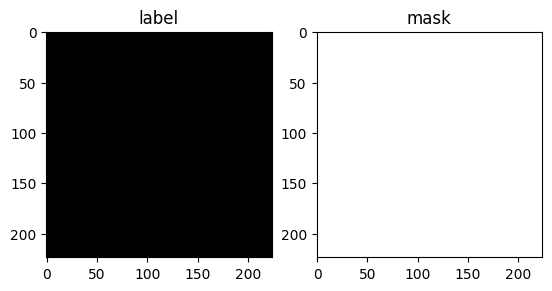

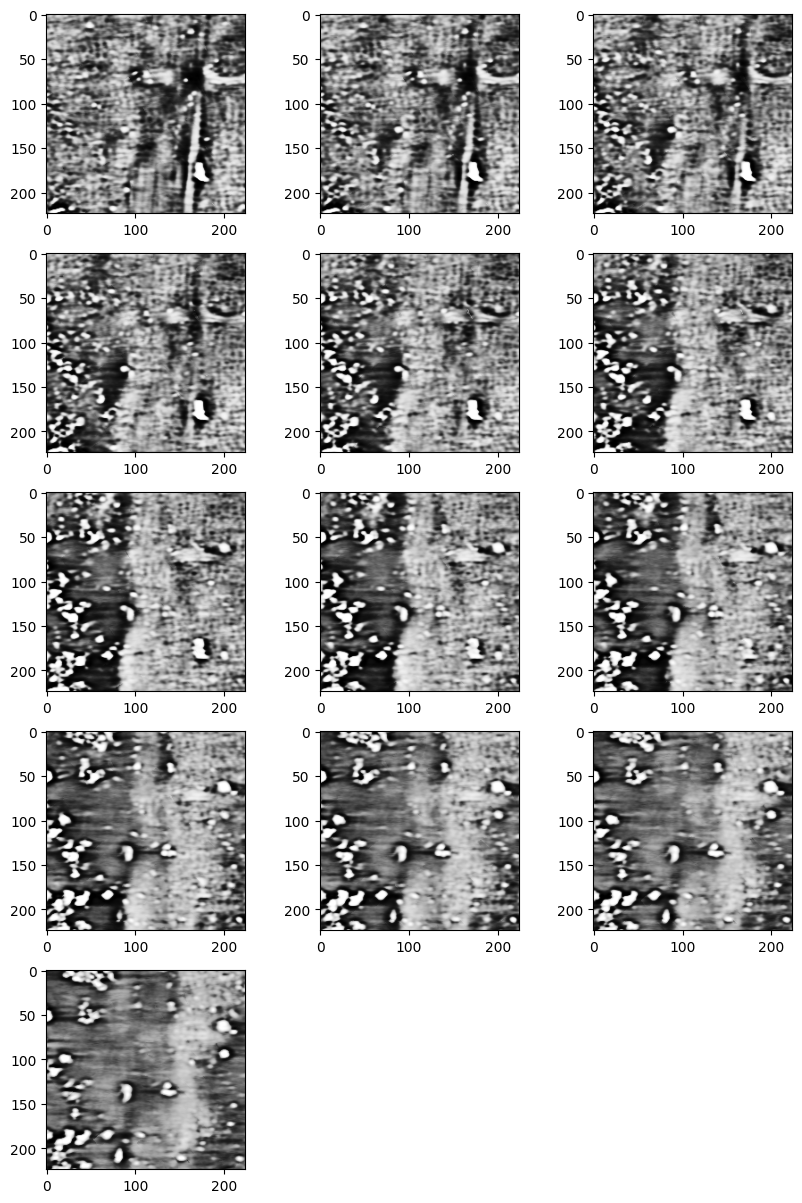

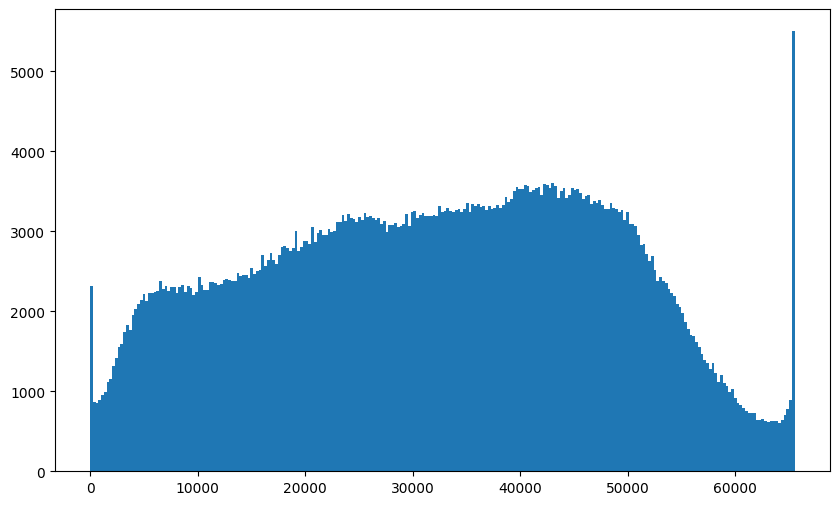

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


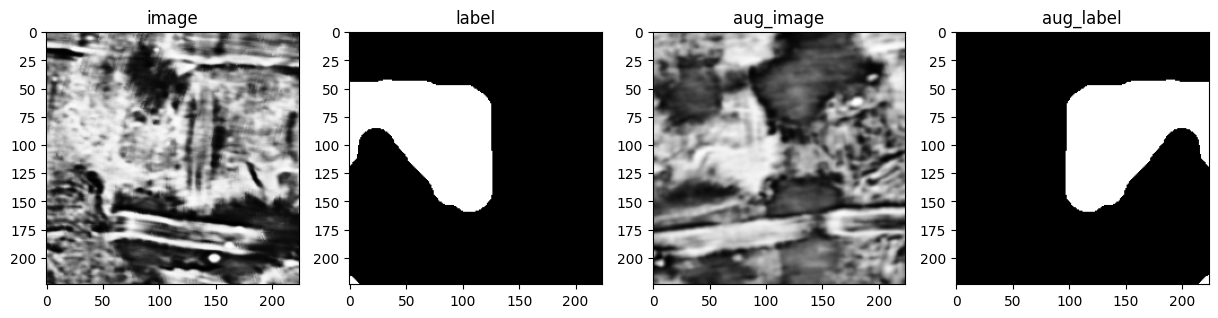

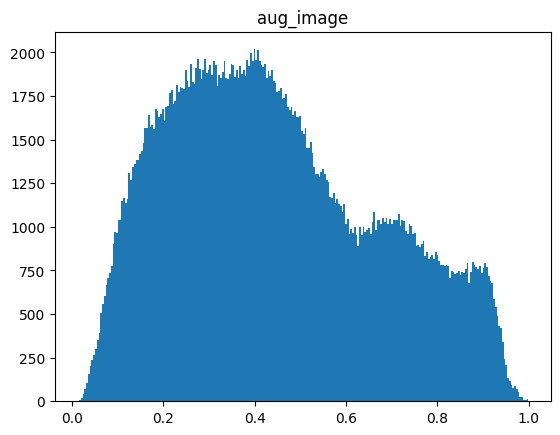

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.12it/s]


fbeta: 0.3135
Epoch 1 - avg_train_loss: 1.4021  avg_val_loss: 1.1543  avgScore: 0.3135  time: 76s
Epoch 1 - Save Best Loss: 1.1543  Best Score: 0.3135 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.92it/s]


fbeta: 0.3373
Epoch 2 - avg_train_loss: 1.1936  avg_val_loss: 1.0892  avgScore: 0.3373  time: 72s
Epoch 2 - Save Best Loss: 1.0892  Best Score: 0.3373 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.88it/s]


fbeta: 0.3631
Epoch 3 - avg_train_loss: 1.0199  avg_val_loss: 0.9446  avgScore: 0.3631  time: 73s
Epoch 3 - Save Best Loss: 0.9446  Best Score: 0.3631 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.77it/s]


fbeta: 0.3716
Epoch 4 - avg_train_loss: 0.9352  avg_val_loss: 1.0099  avgScore: 0.3716  time: 72s
Epoch 4 - Save Best Loss: 1.0099  Best Score: 0.3716 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.89it/s]


fbeta: 0.3786
Epoch 5 - avg_train_loss: 0.8754  avg_val_loss: 0.9601  avgScore: 0.3786  time: 71s
Epoch 5 - Save Best Loss: 0.9601  Best Score: 0.3786 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.85it/s]


fbeta: 0.3979
Epoch 6 - avg_train_loss: 0.8534  avg_val_loss: 0.9514  avgScore: 0.3979  time: 72s
Epoch 6 - Save Best Loss: 0.9514  Best Score: 0.3979 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.88it/s]


fbeta: 0.4250
Epoch 7 - avg_train_loss: 0.8287  avg_val_loss: 0.9251  avgScore: 0.4250  time: 72s
Epoch 7 - Save Best Loss: 0.9251  Best Score: 0.4250 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 22.81it/s]


fbeta: 0.4260
Epoch 8 - avg_train_loss: 0.8230  avg_val_loss: 0.9370  avgScore: 0.4260  time: 72s
Epoch 8 - Save Best Loss: 0.9370  Best Score: 0.4260 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.40it/s]


fbeta: 0.3947
Epoch 9 - avg_train_loss: 0.8083  avg_val_loss: 0.9459  avgScore: 0.3947  time: 72s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.38it/s]


fbeta: 0.4440
Epoch 10 - avg_train_loss: 0.7514  avg_val_loss: 0.9012  avgScore: 0.4440  time: 70s
Epoch 10 - Save Best Loss: 0.9012  Best Score: 0.4440 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.34it/s]


fbeta: 0.4056
Epoch 11 - avg_train_loss: 0.7493  avg_val_loss: 0.9388  avgScore: 0.4056  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.37it/s]


fbeta: 0.4793
Epoch 12 - avg_train_loss: 0.7200  avg_val_loss: 0.8918  avgScore: 0.4793  time: 70s
Epoch 12 - Save Best Loss: 0.8918  Best Score: 0.4793 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.20it/s]


fbeta: 0.4226
Epoch 13 - avg_train_loss: 0.6984  avg_val_loss: 0.9352  avgScore: 0.4226  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.40it/s]


fbeta: 0.4986
Epoch 14 - avg_train_loss: 0.6821  avg_val_loss: 0.9108  avgScore: 0.4986  time: 70s
Epoch 14 - Save Best Loss: 0.9108  Best Score: 0.4986 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.39it/s]


fbeta: 0.4136
Epoch 15 - avg_train_loss: 0.6764  avg_val_loss: 0.9228  avgScore: 0.4136  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.39it/s]


fbeta: 0.4176
Epoch 16 - avg_train_loss: 0.6410  avg_val_loss: 0.9676  avgScore: 0.4176  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.52it/s]


fbeta: 0.4612
Epoch 17 - avg_train_loss: 0.6379  avg_val_loss: 0.9038  avgScore: 0.4612  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.29it/s]


fbeta: 0.4162
Epoch 18 - avg_train_loss: 0.6241  avg_val_loss: 0.9588  avgScore: 0.4162  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.31it/s]


fbeta: 0.4213
Epoch 19 - avg_train_loss: 0.6085  avg_val_loss: 0.9621  avgScore: 0.4213  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.41it/s]


fbeta: 0.4463
Epoch 20 - avg_train_loss: 0.5921  avg_val_loss: 0.9351  avgScore: 0.4463  time: 71s

fold: 1


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.75it/s]


fbeta: 0.3320
Epoch 1 - avg_train_loss: 1.4302  avg_val_loss: 0.8841  avgScore: 0.3320  time: 73s
Epoch 1 - Save Best Loss: 0.8841  Best Score: 0.3320 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.57it/s]


fbeta: 0.3955
Epoch 2 - avg_train_loss: 1.2075  avg_val_loss: 0.8099  avgScore: 0.3955  time: 74s
Epoch 2 - Save Best Loss: 0.8099  Best Score: 0.3955 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.13it/s]


fbeta: 0.4163
Epoch 3 - avg_train_loss: 1.0844  avg_val_loss: 0.6689  avgScore: 0.4163  time: 72s
Epoch 3 - Save Best Loss: 0.6689  Best Score: 0.4163 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.07it/s]


fbeta: 0.5218
Epoch 4 - avg_train_loss: 0.9674  avg_val_loss: 0.6235  avgScore: 0.5218  time: 72s
Epoch 4 - Save Best Loss: 0.6235  Best Score: 0.5218 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.18it/s]


fbeta: 0.4961
Epoch 5 - avg_train_loss: 0.8936  avg_val_loss: 0.6153  avgScore: 0.4961  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.40it/s]


fbeta: 0.4719
Epoch 6 - avg_train_loss: 0.8809  avg_val_loss: 0.6281  avgScore: 0.4719  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.14it/s]


fbeta: 0.5323
Epoch 7 - avg_train_loss: 0.8452  avg_val_loss: 0.6053  avgScore: 0.5323  time: 72s
Epoch 7 - Save Best Loss: 0.6053  Best Score: 0.5323 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.10it/s]


fbeta: 0.5247
Epoch 8 - avg_train_loss: 0.8207  avg_val_loss: 0.5942  avgScore: 0.5247  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.17it/s]


fbeta: 0.5687
Epoch 9 - avg_train_loss: 0.8040  avg_val_loss: 0.5747  avgScore: 0.5687  time: 72s
Epoch 9 - Save Best Loss: 0.5747  Best Score: 0.5687 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.15it/s]


fbeta: 0.4434
Epoch 10 - avg_train_loss: 0.8025  avg_val_loss: 0.6086  avgScore: 0.4434  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.21it/s]


fbeta: 0.5562
Epoch 11 - avg_train_loss: 0.7616  avg_val_loss: 0.5713  avgScore: 0.5562  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.23it/s]


fbeta: 0.5092
Epoch 12 - avg_train_loss: 0.7536  avg_val_loss: 0.5895  avgScore: 0.5092  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.95it/s]


fbeta: 0.5394
Epoch 13 - avg_train_loss: 0.7137  avg_val_loss: 0.5958  avgScore: 0.5394  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.01it/s]


fbeta: 0.5896
Epoch 14 - avg_train_loss: 0.6938  avg_val_loss: 0.5941  avgScore: 0.5896  time: 72s
Epoch 14 - Save Best Loss: 0.5941  Best Score: 0.5896 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.34it/s]


fbeta: 0.5833
Epoch 15 - avg_train_loss: 0.6788  avg_val_loss: 0.5818  avgScore: 0.5833  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.16it/s]


fbeta: 0.6019
Epoch 16 - avg_train_loss: 0.6641  avg_val_loss: 0.5894  avgScore: 0.6019  time: 71s
Epoch 16 - Save Best Loss: 0.5894  Best Score: 0.6019 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.05it/s]


fbeta: 0.5184
Epoch 17 - avg_train_loss: 0.6438  avg_val_loss: 0.6020  avgScore: 0.5184  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.96it/s]


fbeta: 0.5705
Epoch 18 - avg_train_loss: 0.6280  avg_val_loss: 0.5891  avgScore: 0.5705  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.12it/s]


fbeta: 0.5812
Epoch 19 - avg_train_loss: 0.6134  avg_val_loss: 0.6048  avgScore: 0.5812  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.30it/s]


fbeta: 0.5876
Epoch 20 - avg_train_loss: 0.6108  avg_val_loss: 0.5946  avgScore: 0.5876  time: 71s

fold: 2


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.95it/s]


fbeta: 0.3725
Epoch 1 - avg_train_loss: 1.1447  avg_val_loss: 1.1729  avgScore: 0.3725  time: 72s
Epoch 1 - Save Best Loss: 1.1729  Best Score: 0.3725 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.76it/s]


fbeta: 0.4033
Epoch 2 - avg_train_loss: 1.0415  avg_val_loss: 1.1229  avgScore: 0.4033  time: 72s
Epoch 2 - Save Best Loss: 1.1229  Best Score: 0.4033 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.97it/s]


fbeta: 0.4425
Epoch 3 - avg_train_loss: 0.9603  avg_val_loss: 1.1306  avgScore: 0.4425  time: 73s
Epoch 3 - Save Best Loss: 1.1306  Best Score: 0.4425 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.83it/s]


fbeta: 0.5053
Epoch 4 - avg_train_loss: 0.9027  avg_val_loss: 1.0526  avgScore: 0.5053  time: 72s
Epoch 4 - Save Best Loss: 1.0526  Best Score: 0.5053 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.88it/s]


fbeta: 0.4098
Epoch 5 - avg_train_loss: 0.8634  avg_val_loss: 1.1353  avgScore: 0.4098  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.02it/s]


fbeta: 0.5444
Epoch 6 - avg_train_loss: 0.8592  avg_val_loss: 1.0905  avgScore: 0.5444  time: 71s
Epoch 6 - Save Best Loss: 1.0905  Best Score: 0.5444 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.03it/s]


fbeta: 0.4442
Epoch 7 - avg_train_loss: 0.8188  avg_val_loss: 1.0962  avgScore: 0.4442  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.89it/s]


fbeta: 0.5426
Epoch 8 - avg_train_loss: 0.7838  avg_val_loss: 1.1202  avgScore: 0.5426  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.5391
Epoch 9 - avg_train_loss: 0.7662  avg_val_loss: 1.1003  avgScore: 0.5391  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.12it/s]


fbeta: 0.5652
Epoch 10 - avg_train_loss: 0.7676  avg_val_loss: 1.0597  avgScore: 0.5652  time: 71s
Epoch 10 - Save Best Loss: 1.0597  Best Score: 0.5652 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.01it/s]


fbeta: 0.5603
Epoch 11 - avg_train_loss: 0.7395  avg_val_loss: 1.0739  avgScore: 0.5603  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.92it/s]


fbeta: 0.5655
Epoch 12 - avg_train_loss: 0.7135  avg_val_loss: 1.0902  avgScore: 0.5655  time: 72s
Epoch 12 - Save Best Loss: 1.0902  Best Score: 0.5655 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.07it/s]


fbeta: 0.5624
Epoch 13 - avg_train_loss: 0.6905  avg_val_loss: 1.0582  avgScore: 0.5624  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.05it/s]


fbeta: 0.5654
Epoch 14 - avg_train_loss: 0.6634  avg_val_loss: 1.1006  avgScore: 0.5654  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.31it/s]


fbeta: 0.5692
Epoch 15 - avg_train_loss: 0.6446  avg_val_loss: 1.1184  avgScore: 0.5692  time: 72s
Epoch 15 - Save Best Loss: 1.1184  Best Score: 0.5692 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.82it/s]


fbeta: 0.5605
Epoch 16 - avg_train_loss: 0.6353  avg_val_loss: 1.0640  avgScore: 0.5605  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.76it/s]


fbeta: 0.5829
Epoch 17 - avg_train_loss: 0.6289  avg_val_loss: 1.0636  avgScore: 0.5829  time: 72s
Epoch 17 - Save Best Loss: 1.0636  Best Score: 0.5829 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.81it/s]


fbeta: 0.5744
Epoch 18 - avg_train_loss: 0.6029  avg_val_loss: 1.0627  avgScore: 0.5744  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.42it/s]


fbeta: 0.5786
Epoch 19 - avg_train_loss: 0.6052  avg_val_loss: 1.0617  avgScore: 0.5786  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.80it/s]


fbeta: 0.5780
Epoch 20 - avg_train_loss: 0.5826  avg_val_loss: 1.0850  avgScore: 0.5780  time: 73s

fold: 3


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.19it/s]


fbeta: 0.3622
Epoch 1 - avg_train_loss: 1.3639  avg_val_loss: 1.1222  avgScore: 0.3622  time: 73s
Epoch 1 - Save Best Loss: 1.1222  Best Score: 0.3622 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.19it/s]


fbeta: 0.3999
Epoch 2 - avg_train_loss: 1.1699  avg_val_loss: 1.0673  avgScore: 0.3999  time: 73s
Epoch 2 - Save Best Loss: 1.0673  Best Score: 0.3999 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.37it/s]


fbeta: 0.3910
Epoch 3 - avg_train_loss: 1.0304  avg_val_loss: 0.9899  avgScore: 0.3910  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.44it/s]


fbeta: 0.5220
Epoch 4 - avg_train_loss: 0.9011  avg_val_loss: 0.9058  avgScore: 0.5220  time: 72s
Epoch 4 - Save Best Loss: 0.9058  Best Score: 0.5220 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.29it/s]


fbeta: 0.5282
Epoch 5 - avg_train_loss: 0.8937  avg_val_loss: 0.9355  avgScore: 0.5282  time: 72s
Epoch 5 - Save Best Loss: 0.9355  Best Score: 0.5282 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.37it/s]


fbeta: 0.5509
Epoch 6 - avg_train_loss: 0.8547  avg_val_loss: 0.8982  avgScore: 0.5509  time: 72s
Epoch 6 - Save Best Loss: 0.8982  Best Score: 0.5509 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.36it/s]


fbeta: 0.5468
Epoch 7 - avg_train_loss: 0.8573  avg_val_loss: 0.9262  avgScore: 0.5468  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.59it/s]


fbeta: 0.5533
Epoch 8 - avg_train_loss: 0.8264  avg_val_loss: 0.9062  avgScore: 0.5533  time: 72s
Epoch 8 - Save Best Loss: 0.9062  Best Score: 0.5533 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.89it/s]


fbeta: 0.5511
Epoch 9 - avg_train_loss: 0.7920  avg_val_loss: 0.8950  avgScore: 0.5511  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.65it/s]


fbeta: 0.6065
Epoch 10 - avg_train_loss: 0.7768  avg_val_loss: 0.8724  avgScore: 0.6065  time: 71s
Epoch 10 - Save Best Loss: 0.8724  Best Score: 0.6065 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.52it/s]


fbeta: 0.5903
Epoch 11 - avg_train_loss: 0.7582  avg_val_loss: 0.9017  avgScore: 0.5903  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.46it/s]


fbeta: 0.5263
Epoch 12 - avg_train_loss: 0.7628  avg_val_loss: 0.9024  avgScore: 0.5263  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.74it/s]


fbeta: 0.6262
Epoch 13 - avg_train_loss: 0.7238  avg_val_loss: 0.8796  avgScore: 0.6262  time: 72s
Epoch 13 - Save Best Loss: 0.8796  Best Score: 0.6262 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.35it/s]


fbeta: 0.5846
Epoch 14 - avg_train_loss: 0.7156  avg_val_loss: 0.8888  avgScore: 0.5846  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.48it/s]


fbeta: 0.5676
Epoch 15 - avg_train_loss: 0.6900  avg_val_loss: 0.8897  avgScore: 0.5676  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.67it/s]


fbeta: 0.6076
Epoch 16 - avg_train_loss: 0.6706  avg_val_loss: 0.8708  avgScore: 0.6076  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.50it/s]


fbeta: 0.5943
Epoch 17 - avg_train_loss: 0.6556  avg_val_loss: 0.8944  avgScore: 0.5943  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.50it/s]


fbeta: 0.5626
Epoch 18 - avg_train_loss: 0.6406  avg_val_loss: 0.8948  avgScore: 0.5626  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.68it/s]


fbeta: 0.6005
Epoch 19 - avg_train_loss: 0.6269  avg_val_loss: 0.8996  avgScore: 0.6005  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.73it/s]


fbeta: 0.5932
Epoch 20 - avg_train_loss: 0.6179  avg_val_loss: 0.8983  avgScore: 0.5932  time: 71s

fold: 4


100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 21.68it/s]


fbeta: 0.2429
Epoch 1 - avg_train_loss: 1.2712  avg_val_loss: 1.1607  avgScore: 0.2429  time: 75s
Epoch 1 - Save Best Loss: 1.1607  Best Score: 0.2429 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 21.94it/s]


fbeta: 0.3652
Epoch 2 - avg_train_loss: 1.1102  avg_val_loss: 0.9286  avgScore: 0.3652  time: 75s
Epoch 2 - Save Best Loss: 0.9286  Best Score: 0.3652 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.09it/s]


fbeta: 0.4595
Epoch 3 - avg_train_loss: 1.0004  avg_val_loss: 0.7549  avgScore: 0.4595  time: 74s
Epoch 3 - Save Best Loss: 0.7549  Best Score: 0.4595 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.49it/s]


fbeta: 0.4128
Epoch 4 - avg_train_loss: 0.9248  avg_val_loss: 0.7775  avgScore: 0.4128  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.35it/s]


fbeta: 0.3719
Epoch 5 - avg_train_loss: 0.8873  avg_val_loss: 0.8425  avgScore: 0.3719  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.30it/s]


fbeta: 0.3202
Epoch 6 - avg_train_loss: 0.8673  avg_val_loss: 0.9589  avgScore: 0.3202  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.22it/s]


fbeta: 0.4309
Epoch 7 - avg_train_loss: 0.8311  avg_val_loss: 0.7784  avgScore: 0.4309  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.43it/s]


fbeta: 0.3878
Epoch 8 - avg_train_loss: 0.8141  avg_val_loss: 0.8221  avgScore: 0.3878  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.32it/s]


fbeta: 0.3934
Epoch 9 - avg_train_loss: 0.8021  avg_val_loss: 0.8813  avgScore: 0.3934  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.25it/s]


fbeta: 0.4951
Epoch 10 - avg_train_loss: 0.7606  avg_val_loss: 0.7167  avgScore: 0.4951  time: 74s
Epoch 10 - Save Best Loss: 0.7167  Best Score: 0.4951 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.38it/s]


fbeta: 0.4266
Epoch 11 - avg_train_loss: 0.7300  avg_val_loss: 0.7706  avgScore: 0.4266  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.12it/s]


fbeta: 0.4550
Epoch 12 - avg_train_loss: 0.7132  avg_val_loss: 0.7595  avgScore: 0.4550  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.33it/s]


fbeta: 0.4923
Epoch 13 - avg_train_loss: 0.7155  avg_val_loss: 0.7103  avgScore: 0.4923  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.31it/s]


fbeta: 0.5051
Epoch 14 - avg_train_loss: 0.6811  avg_val_loss: 0.7336  avgScore: 0.5051  time: 73s
Epoch 14 - Save Best Loss: 0.7336  Best Score: 0.5051 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.47it/s]


fbeta: 0.4831
Epoch 15 - avg_train_loss: 0.6702  avg_val_loss: 0.7373  avgScore: 0.4831  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.21it/s]


fbeta: 0.4888
Epoch 16 - avg_train_loss: 0.6438  avg_val_loss: 0.7366  avgScore: 0.4888  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.38it/s]


fbeta: 0.4731
Epoch 17 - avg_train_loss: 0.6143  avg_val_loss: 0.7582  avgScore: 0.4731  time: 75s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.60it/s]


fbeta: 0.4732
Epoch 18 - avg_train_loss: 0.6056  avg_val_loss: 0.7509  avgScore: 0.4732  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.52it/s]


fbeta: 0.4634
Epoch 19 - avg_train_loss: 0.5829  avg_val_loss: 0.7612  avgScore: 0.4634  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.19it/s]


fbeta: 0.4774
Epoch 20 - avg_train_loss: 0.5798  avg_val_loss: 0.7528  avgScore: 0.4774  time: 74s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.4986
fbeta: 0.6019
fbeta: 0.5829
fbeta: 0.6262
fbeta: 0.5051


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5639


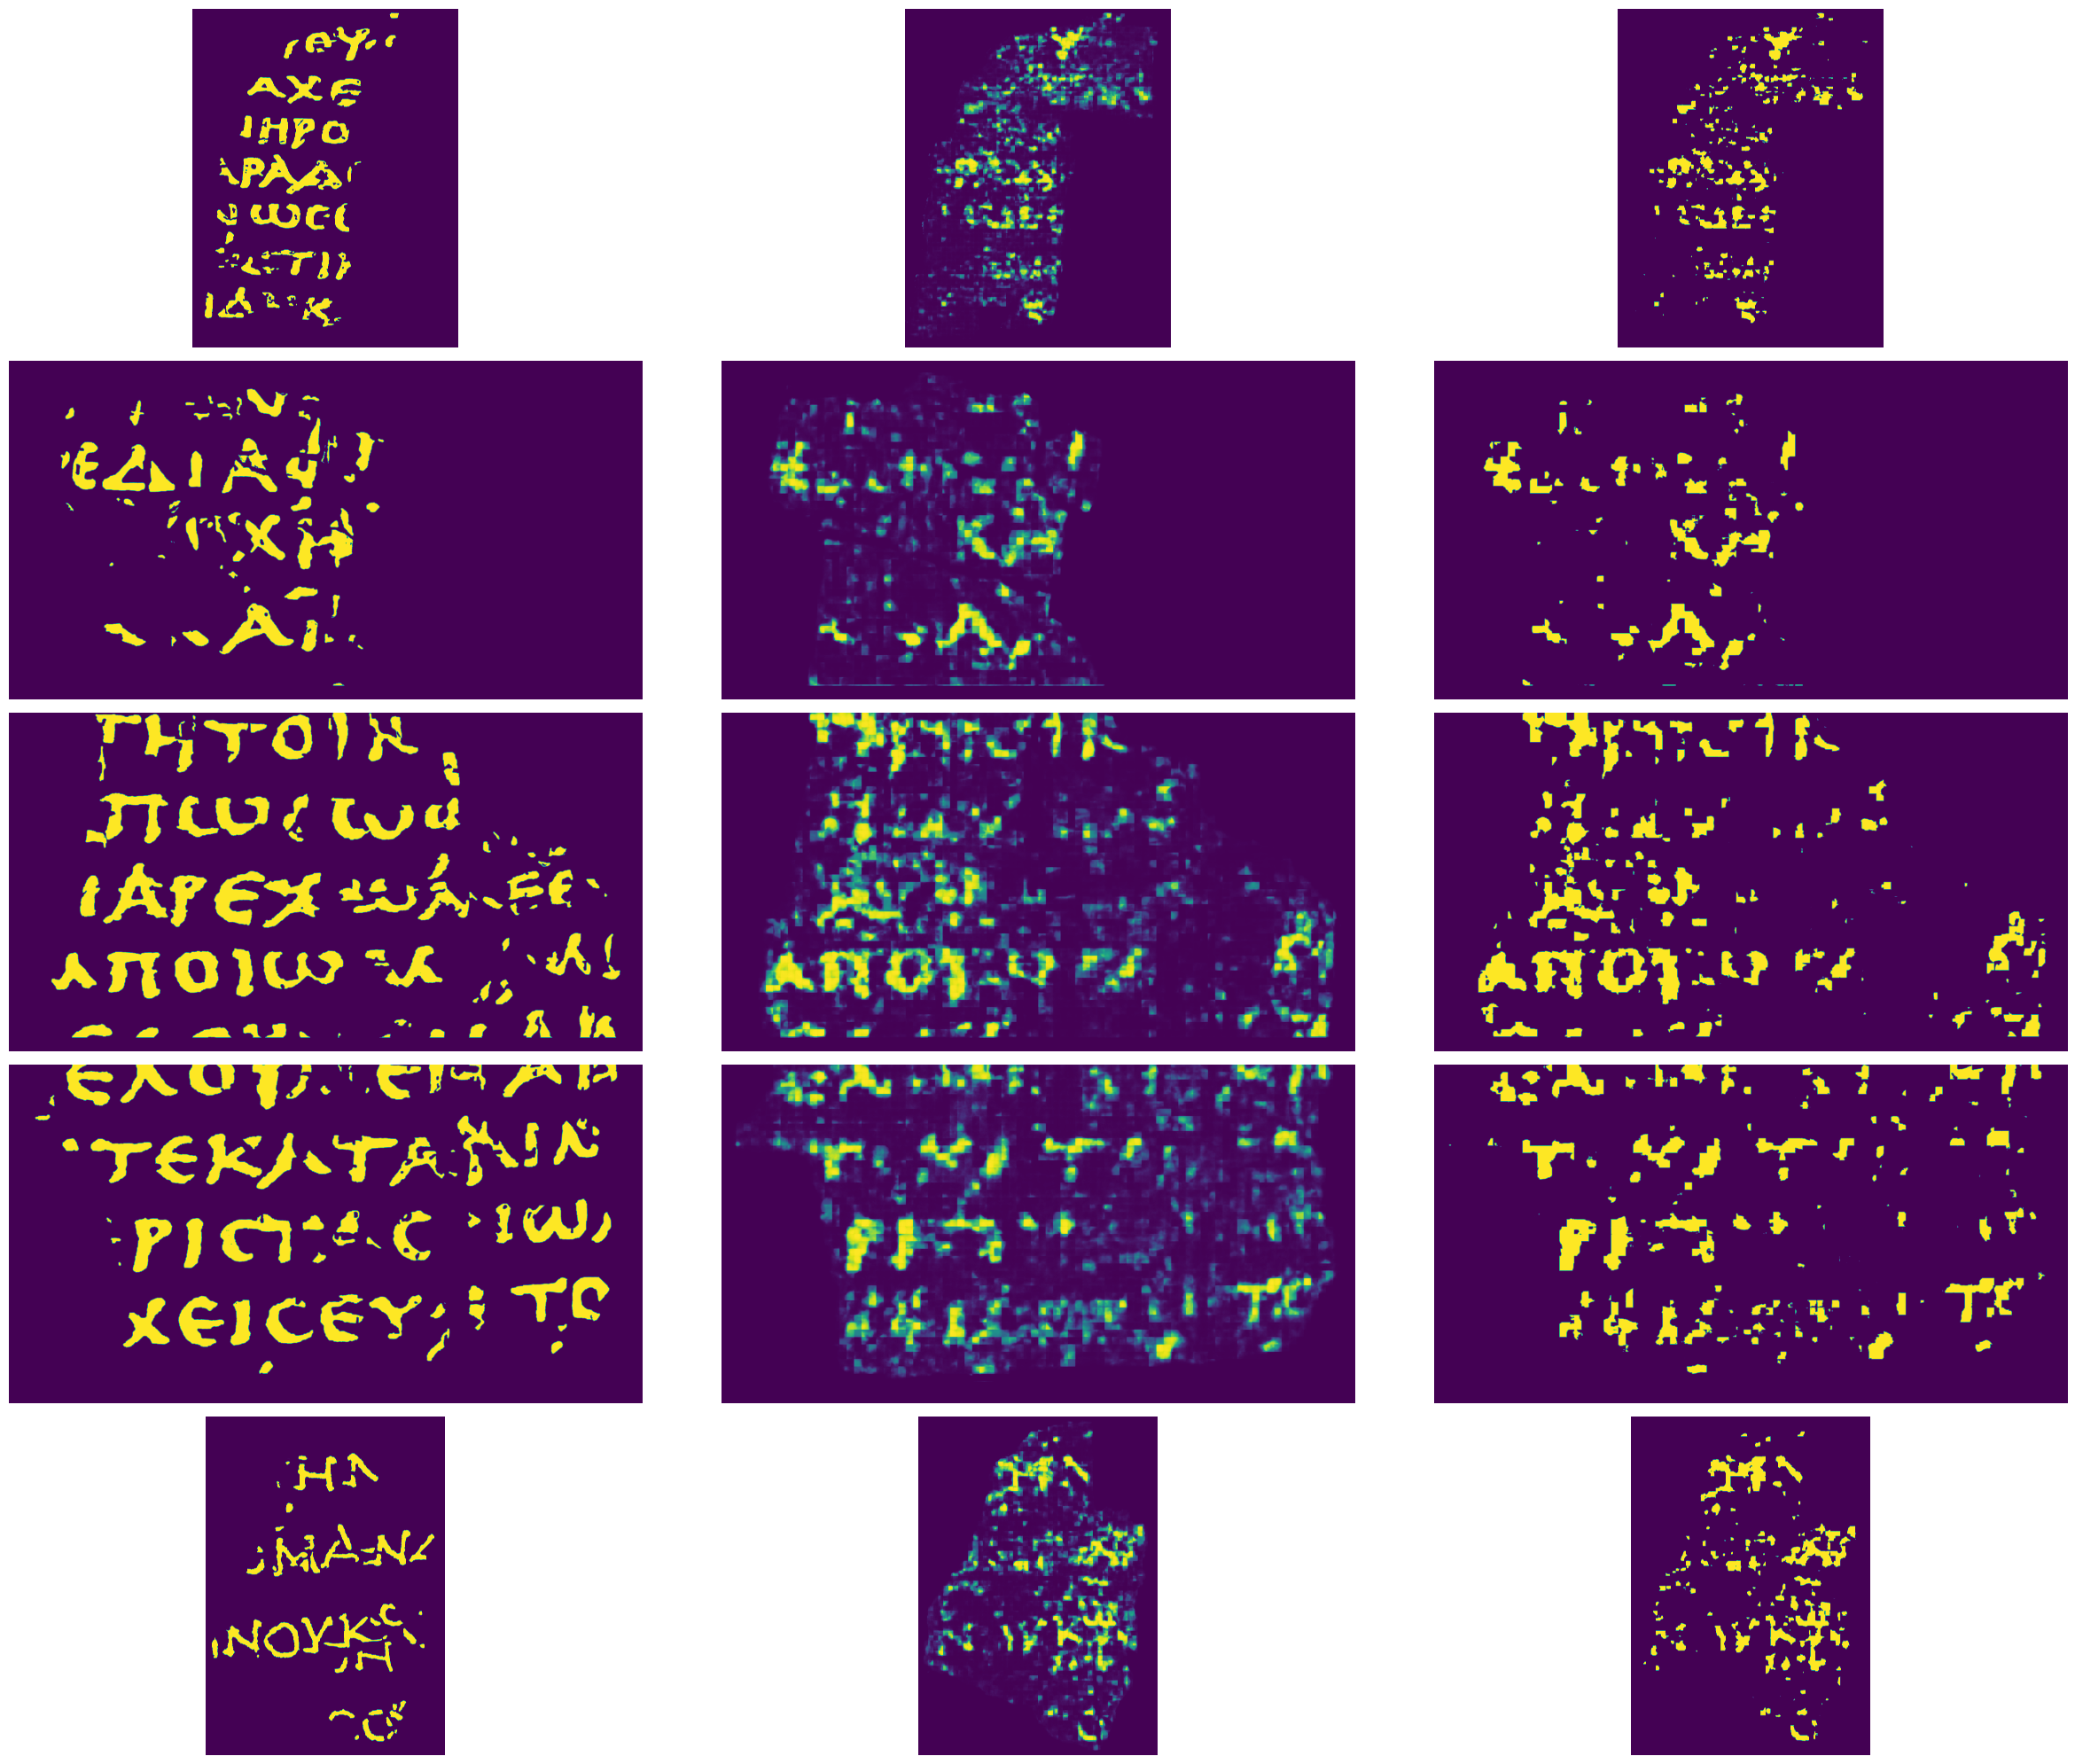

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)